# Example 01. Gridding of the scan data

This example generates grids in spherical and scan coordinate systems. Aside from simply visualizing your scan and exporting them to an open image format format (e.g., GeoTiff), these also allow you to check for instrument artefacts and azimuth/zenith angles ranges to use in the estimation of vertical plant profiles. These are some useful tools for sigle scans and/or directional gap probability modeling, however more standard point cloud processing (e.g., point labelling such as ground classification, co-registration with UAV-LS and ALS data) is better done using dedicated software.

## Load all the required modules

In [1]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

from riegl_canopy import riegl_io, grid

## Some plotting functions

In [2]:
def plot_riegl_grid(data, label='Range (m)', clim=[0,30], figsize=(16,10), nbins=10,
                    cmap='bone', nreturns=None, extend='max', nodata=-9999, extent=None,
                    xlabel=None, ylabel=None, facecolor='white'):
    """Example function to plot a RIEGL grid"""
    if nreturns is None:
        nreturns = data.shape[0]
    fig, ax = plt.subplots(ncols=1, nrows=nreturns, squeeze=False, 
                           sharex=True, sharey=True, figsize=figsize)
    with plt.style.context('seaborn-notebook'):
        for i in range(nreturns):  
            ax[i,0].set_facecolor(facecolor)
            ax[i,0].set(adjustable='box', aspect='equal')
            ax[i,0].set(xlabel=xlabel, ylabel=ylabel)
            if extent is None:
                ax[i,0].get_xaxis().set_visible(False)
                ax[i,0].get_yaxis().set_visible(False)
            tmp = np.ma.masked_equal(data[i], nodata)
            p = ax[i,0].imshow(tmp, interpolation='nearest', clim=clim, 
                               cmap=matplotlib.cm.get_cmap(cmap,nbins),  
                               vmin=clim[0], vmax=clim[1], extent=extent)
            divider = make_axes_locatable(ax[i,0])
            cax = divider.append_axes('right', size='2%', pad=0.05)
            cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
            cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=nbins))
    fig.tight_layout()
    plt.show()


## Identify all of the input files

If you are using a RIEGL VZ400 scanner or used a pulse rate <= 300khz, then you only need the RXP files for point cloud data.

In [3]:
os.chdir('/gpfs/data1/vclgp/data/tls_point_clouds/riegl_registered/maeda_Amazon_Dimona-100ha-SOUTH.RiSCAN')

# Upright scan files
upright_rxp_fn = 'SCANS/ScanPos001/SINGLESCANS/190426_112319.rxp'
upright_rdbx_fn = 'project.rdb/SCANS/ScanPos001/SINGLESCANS/190426_112319/190426_112319.rdbx'
upright_transform_fn = 'project.rdb/SCANS/ScanPos001.DAT'

# Tilt scan files
tilt_rxp_fn = 'SCANS/ScanPos002/SINGLESCANS/190426_112552.rxp'
tilt_rdbx_fn = 'project.rdb/SCANS/ScanPos002/SINGLESCANS/190426_112552/190426_112552.rdbx'
tilt_transform_fn = 'project.rdb/SCANS/ScanPos002.DAT'

## Grid and visualize the scan data

### RDBX point data in the scan coordinate system

The scan coordinate system is scan line (x-axis), scan line index (y-axis) and return number (z-axis). Each cell contains the data for one shot. The RDBX files only have data for shots with returns - nothing is retained for shots without returns.

In [4]:
upright_reflectance_grid = grid.grid_rdbx_scan(upright_rdbx_fn, attribute='reflectance')

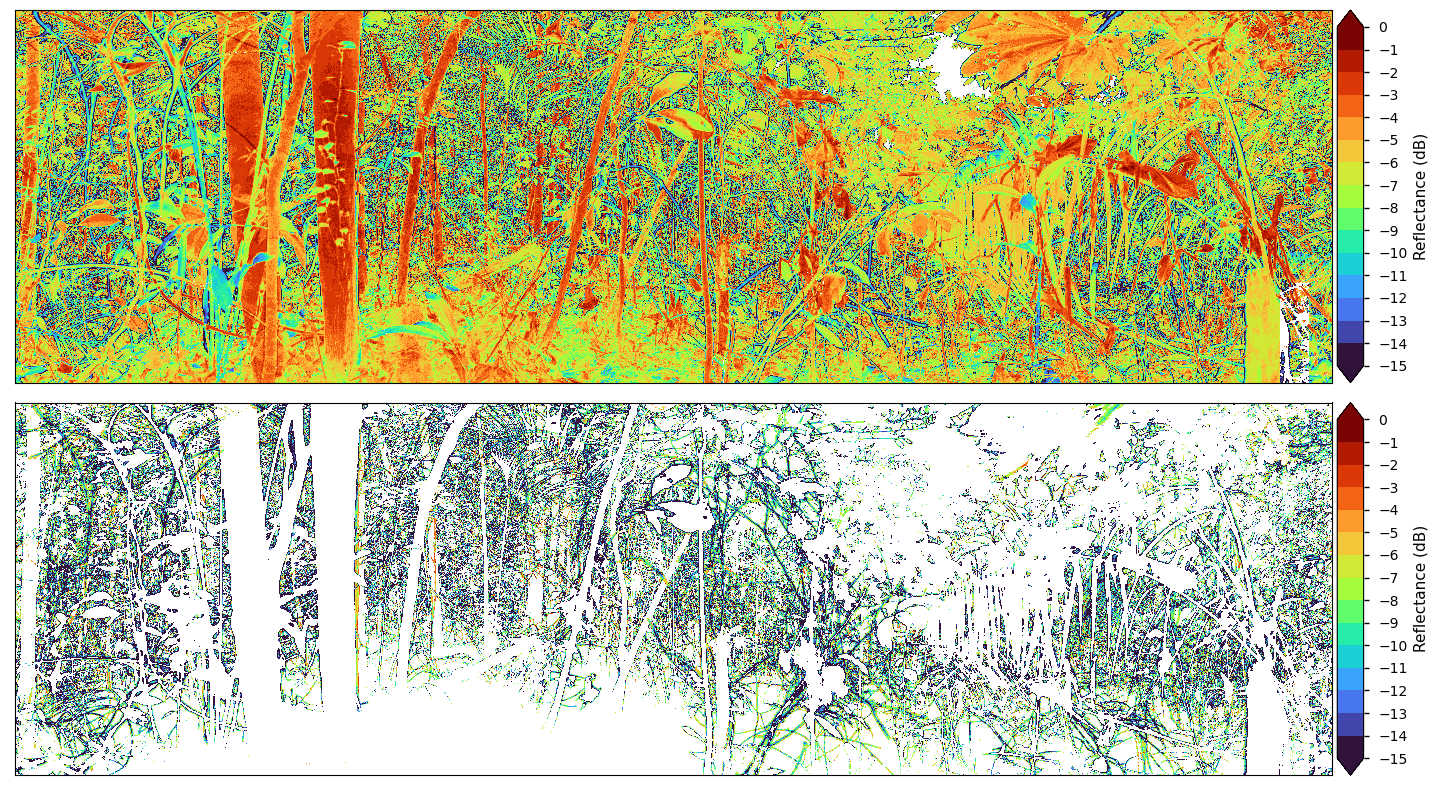

In [31]:
plot_riegl_grid(upright_reflectance_grid, label='Reflectance (dB)', nreturns=2, clim=[-15,0],
                figsize=(16,8), nbins=15, cmap='turbo', extend='both', facecolor='white')

In [6]:
tilt_reflectance_grid = grid.grid_rdbx_scan(tilt_rdbx_fn, attribute='reflectance')

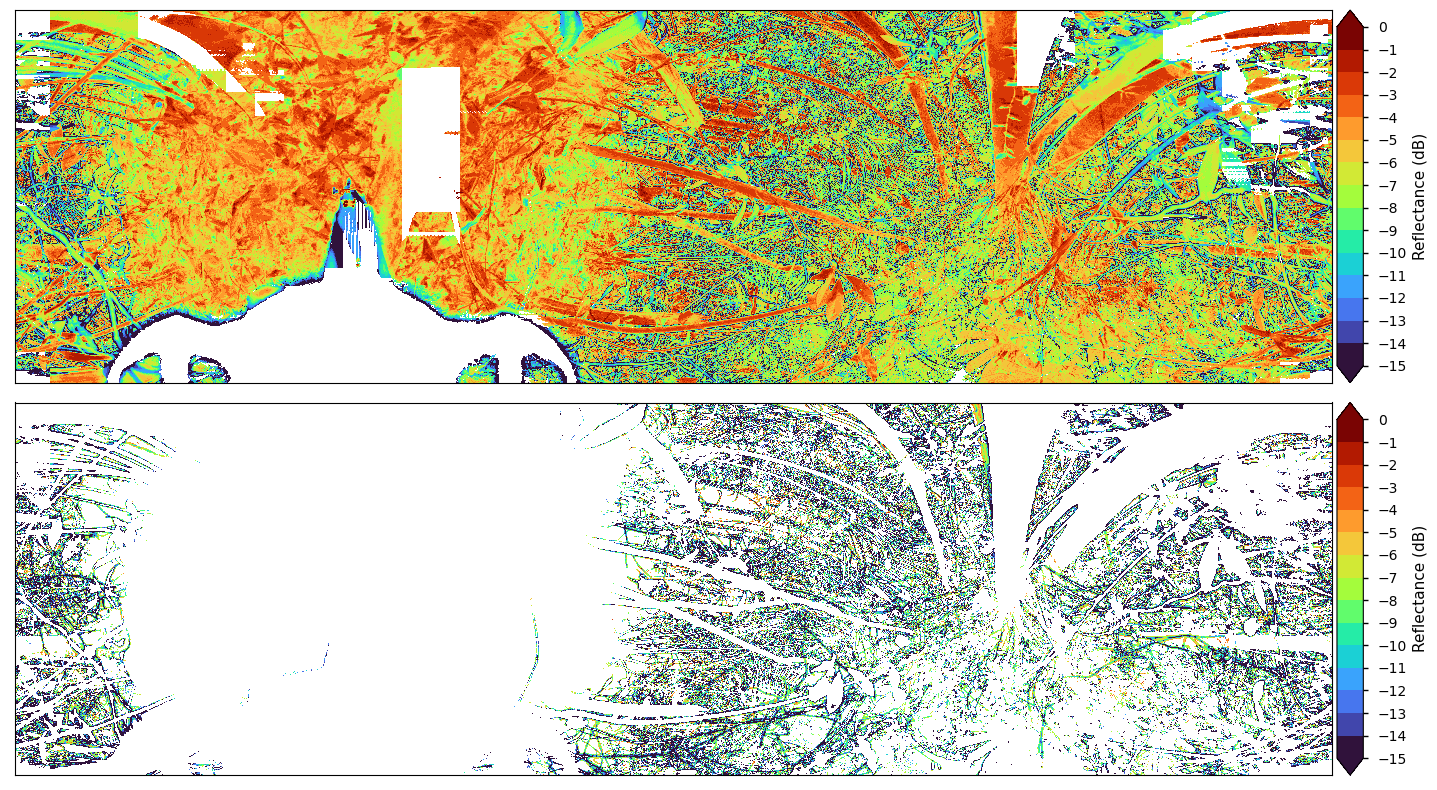

In [32]:
plot_riegl_grid(tilt_reflectance_grid, label='Reflectance (dB)', nreturns=2, clim=[-15,0],
                figsize=(16,8), nbins=15, cmap='turbo', extend='both', facecolor='white')

### RXP pulse data in the scan coordinate system

The RXP files have data for all shots with returns, even if there are no returns for that shot. However the VZ400i and later instruments, and/or scans with a pulse rate > 300 kHz, use multi-time-around (MTA) processing to allow more than one pulse in the air at a time. This means there may be ambigutity on which shot a return belongs to, so the RDBX files should be used for point cloud measurements.

In [8]:
upright_count_grid = grid.grid_rxp_scan(upright_rxp_fn, attribute='target_count')

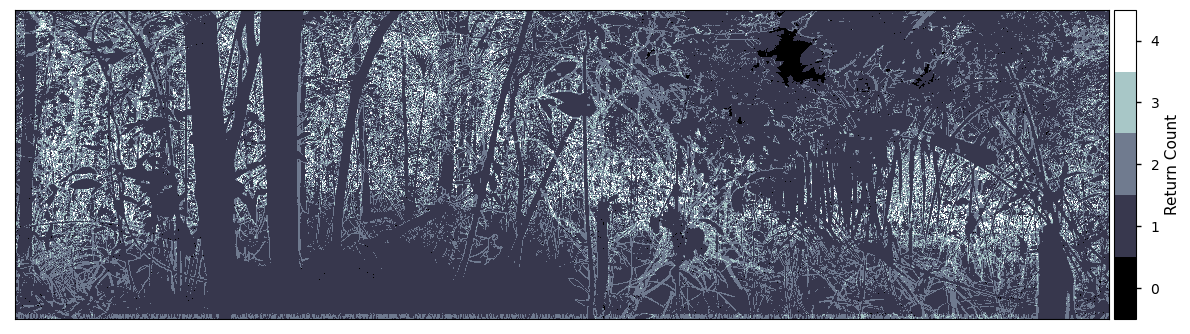

In [33]:
plot_riegl_grid(upright_count_grid, label='Return Count', clim=[-0.5,4.5], figsize=(12,8), 
                nbins=5, cmap='bone', extend='neither', facecolor='lightyellow')

### RDBX point data in the spherical coordinate system

The spherical coordinate system is azimuth ($\phi$, x-axis), zenith ($\theta$, y-axis) and range ($r$, z-axis), which is used in the derivation of vertical profiles based on the directional gap probability, $P_{gap}$($\phi$, $\theta$, $r$). Note that RDBX files have no data for shots with no return, so we can't easily separate a gap from the absence of a measurement.

In [10]:
upright_range_grid = grid.grid_rdbx_spherical(upright_rdbx_fn, upright_transform_fn, 0.1, 
                                              attribute='range', first_only=True, method='MEAN')

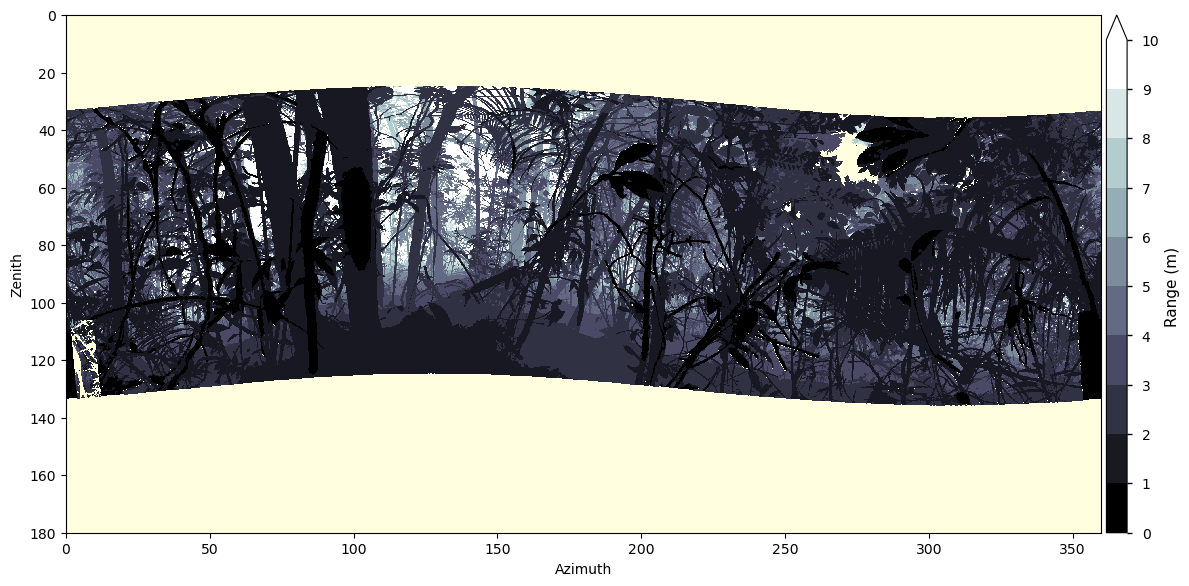

In [28]:
plot_riegl_grid(upright_range_grid, label='Range (m)', clim=[0,10], figsize=(12,8), 
                nbins=10, cmap='bone', extent=[0,360,180,0], 
                xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow')

In [12]:
tilt_range_grid = grid.grid_rdbx_spherical(tilt_rdbx_fn, tilt_transform_fn, 0.1, 
                                           attribute='range', first_only=True)

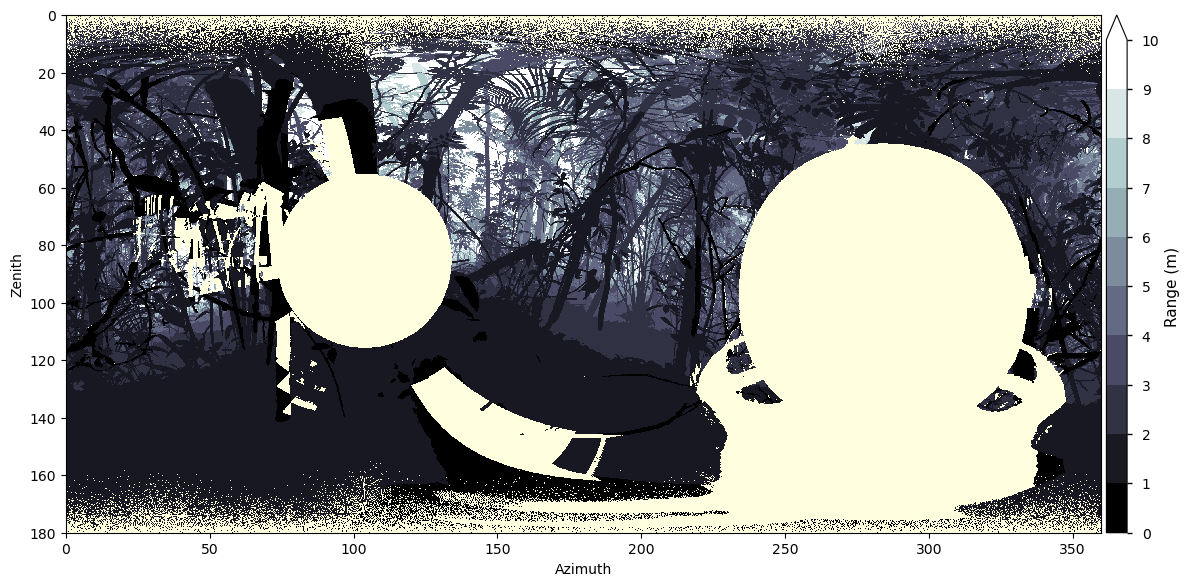

In [29]:
plot_riegl_grid(tilt_range_grid, label='Range (m)', clim=[0,10], figsize=(12,8), 
                nbins=10, cmap='bone', extent=[0,360,180,0], 
                xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow')

### RXP pulse data in the spherical coordinate system

We extract pulse direction vectors from the RXP instead of RDBX files. An alternative solution is to interpolate shot direction vectors from the shots with returns, however there is no need because we have the actual measurements in the RXP files. There can also be interpolation errors, especially in sparse sites, and this approach does not account for missing data (e.g., resulting from near range, <1.5 m, occlusion).

In [14]:
upright_zenith_grid = grid.grid_rxp_spherical(upright_rxp_fn, upright_transform_fn, 0.1, 
                                              attribute='zenith')

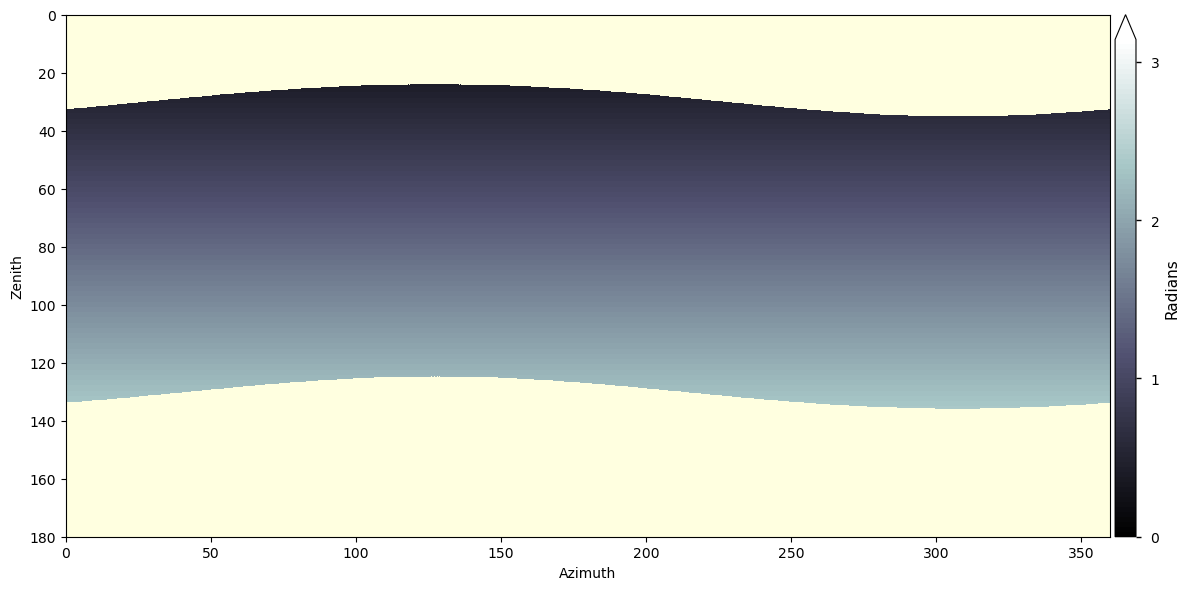

In [34]:
plot_riegl_grid(upright_zenith_grid, label='Radians', clim=[0,np.pi], figsize=(12,8), 
                nbins=100, cmap='bone', extent=[0,360,180,0], 
                xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow')

In [16]:
tilt_zenith_grid = grid.grid_rxp_spherical(tilt_rxp_fn, tilt_transform_fn, 0.1, 
                                           attribute='zenith')

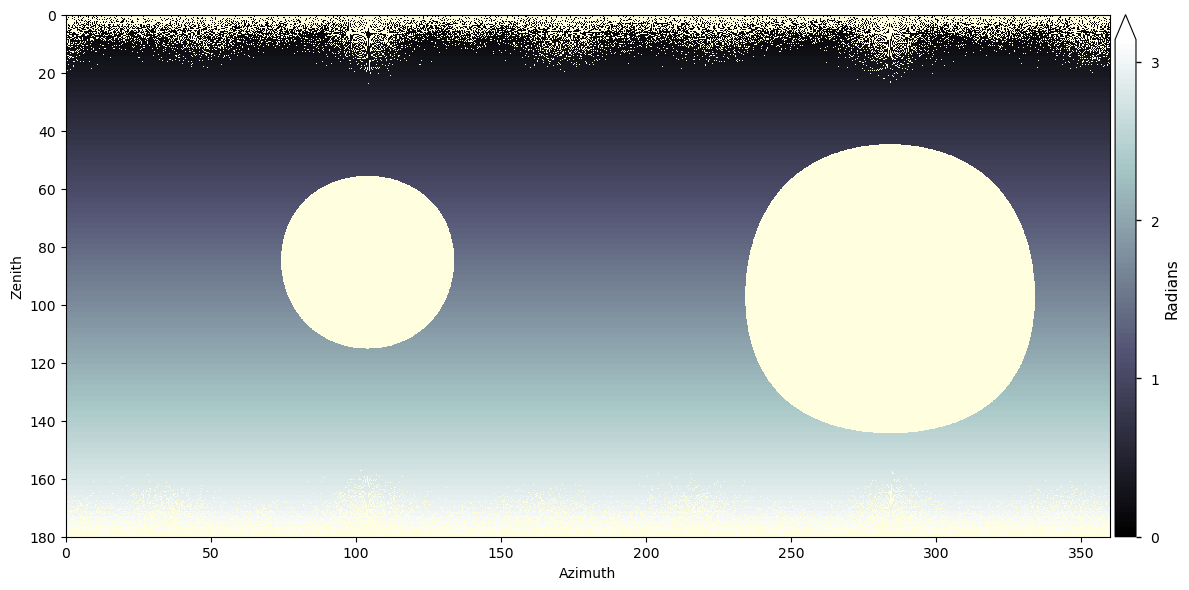

In [35]:
plot_riegl_grid(tilt_zenith_grid, label='Radians', clim=[0,np.pi], figsize=(12,8), 
                nbins=100, cmap='bone', extent=[0,360,180,0], 
                xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow')

### RDBX point data in the cartesian SOC coordinate system

The point cloud data in the RDBX files can also be gridded in the sensor origin coordinate (SOC) cartesian coordinate system. This can be useful for checking the results of plane fitting (see 'Example 02. Generate a single scan PAVD profile'), deriving canopy height models, or visualizing and modeling the "star", which is related to canopy structure and complexity.

In [20]:
xsize = ysize = 50
z_grid = grid.grid_rdbx_cartesian([upright_rdbx_fn,tilt_rdbx_fn], [upright_transform_fn,tilt_transform_fn], 
                                  0.1, extent=[xsize,ysize], ulc=[-xsize/2,ysize/2], attribute='z', 
                                  method='MAX')

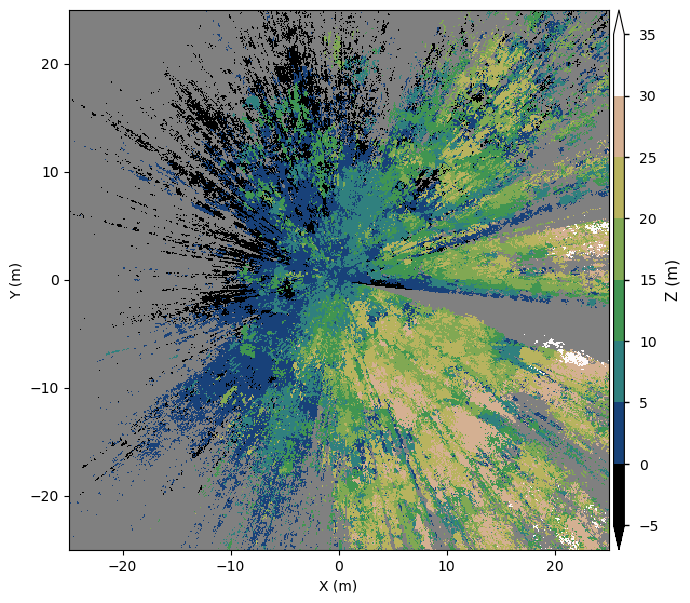

In [25]:
plot_riegl_grid(z_grid, label='Z (m)', clim=[-5,35], figsize=(7,7), 
                nbins=8, cmap='gist_earth', extent=[-xsize/2,xsize/2,-ysize/2,ysize/2], 
                xlabel='X (m)', ylabel='Y (m)', facecolor='0.5', extend='both')